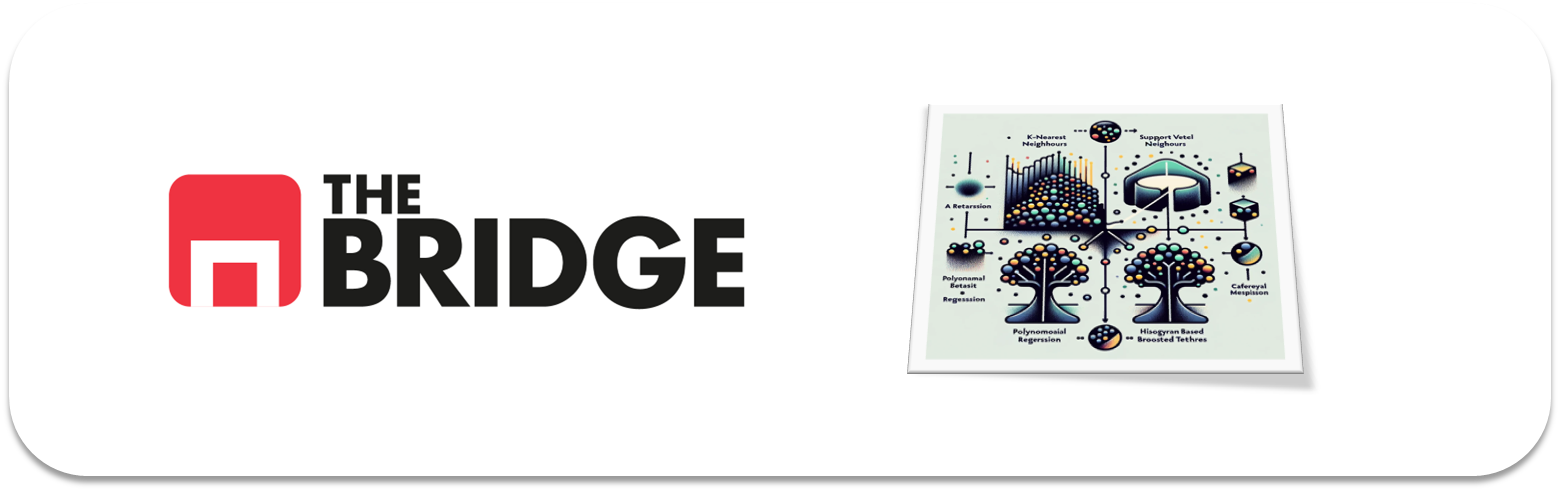

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descargar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier, XGBRegressor

from utils import datascience as ds
from utils import machinelearningtools as ml
from utils import vizdatatools as viz

In [2]:
np.__version__

'1.26.4'

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [3]:
df_wine = pd.read_csv('./data/wines_dataset.csv', sep='|')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


In [4]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
# Variable categórica, pero NO tengo casos de las clases 0, 1, 2, 3 y 10. ¿Entonces podré aprender a predecir esos valores?
df_wine['quality'].unique()

array([6, 7, 3, 5, 4, 8, 9], dtype=int64)

In [6]:
# Variable claramente numérica
df_wine['alcohol'].nunique()

111

*Para el problema de clasificación, nuestro target es "quality". Pero NO tengo casos de las clases 0, 1, 2, 3 y 10. ¿Entonces podré aprender a predecir esos valores?*

*Para el problema de regresión, nuestro target es "alcohol".*

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

`Está resuelto en el otro Jupyter Notebook. De echo emplearé cosas de él aquí.`

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. 

Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

### 3.1 Entendiendo el problema

Es un problema de regresiónle, donde la métrica que se intentará mejorar es el "racall_medio"

### 3.2 Primer análisis de los datos

In [7]:
df_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [8]:
ds.get_cardinality(df_wine)

pandas.DataFrame shape:  (6497, 13)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
fixed acidity,106,1.631522,0,0.0,float64,Numeric - Discrete
volatile acidity,187,2.878252,0,0.0,float64,Numeric - Discrete
citric acid,89,1.369863,0,0.0,float64,Numeric - Discrete
residual sugar,316,4.863783,0,0.0,float64,Numeric - Discrete
chlorides,214,3.293828,0,0.0,float64,Numeric - Discrete
free sulfur dioxide,135,2.077882,0,0.0,float64,Numeric - Discrete
total sulfur dioxide,276,4.248115,0,0.0,float64,Numeric - Discrete
density,998,15.360936,0,0.0,float64,Numeric - Discrete
pH,108,1.662306,0,0.0,float64,Numeric - Discrete
sulphates,111,1.708481,0,0.0,float64,Numeric - Discrete


A excepción de "quality" y "class", todas las variables son numéricas, y nuestro target para esta regresión es: "alcohol".

### 3.3 Split de train y test para no contaminar.

In [9]:
target_reg = 'alcohol'

# Para la regresión estratificar no asegura la distribución óptima del target (que queremos que se parezca a una campana de Gauss)
train_set, test_set = train_test_split(df_wine, test_size=0.2, random_state=42)

X_train = train_set.drop(columns=target_reg)
X_test = test_set.drop(columns=target_reg)
y_train = train_set[target_reg]
y_test = test_set[target_reg]

### 3.4 Mini EDA

#### 3.4.1 Analizar la distribución del target brevemente (univariante)

<Axes: xlabel='alcohol', ylabel='Count'>

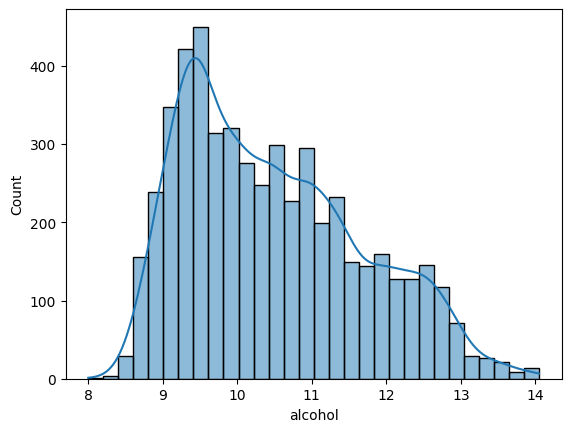

In [10]:
sns.histplot(y_train, kde=True)

*La distribución no tiene cierta "normalidad", que es buena para la regresión lineal, aunque no vayamos a utilizar ese modelo, en general "nos gusta" que tenga esa distribución, porque también es importante para modelos basasdos en distancias.* 

A continuación algunas transformaciones no lineales simples que podrían mejorar la distribución del target. Además como veo que el valor mínimo del target no cae en 0, no voy a preocuparme de los errores que podria tener el logaritmo.

<Axes: xlabel='alcohol', ylabel='Count'>

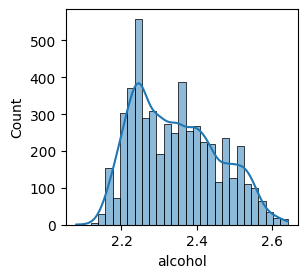

In [11]:
# Logaritmo
plt.figure(figsize=(3, 2.8))
sns.histplot(np.log(y_train), kde=True)

<Axes: xlabel='alcohol', ylabel='Count'>

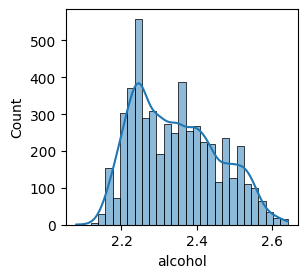

In [12]:
# Raíz cuadrada
plt.figure(figsize=(3, 2.8))
sns.histplot(np.log(y_train), kde=True)

Estas transformaciones no han servido de mucho, así que voy a dejarlo como estaba originalmente.

#### 3.4.2 Análisis bivariante de las variables categóricas con el target

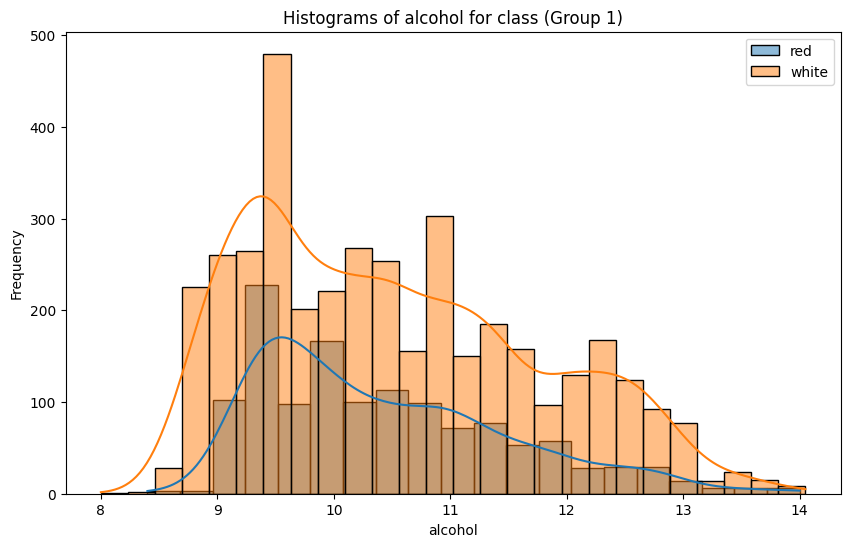

In [13]:
viz.plot_histograms_grouped(train_set, 'class', target_reg)

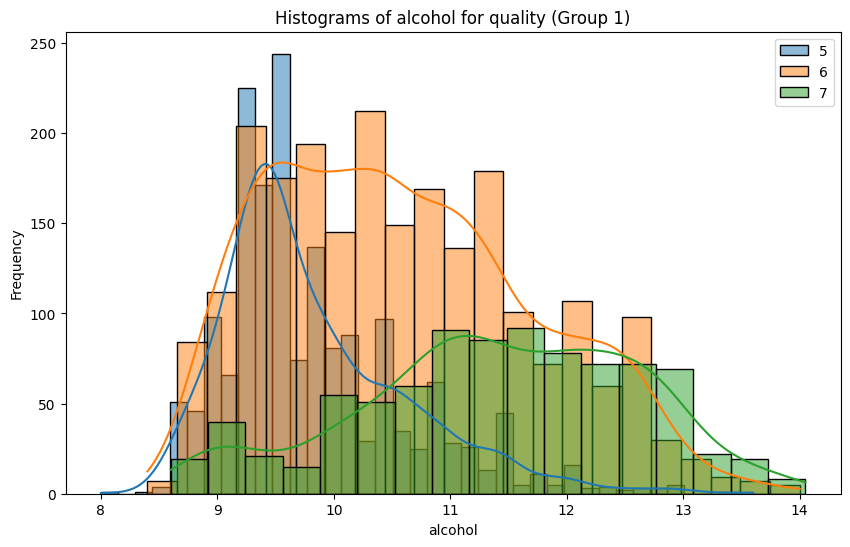

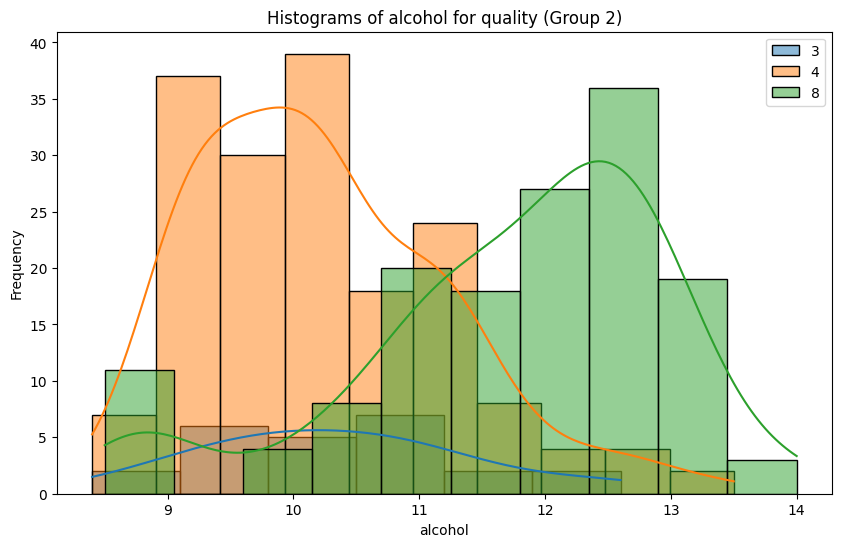

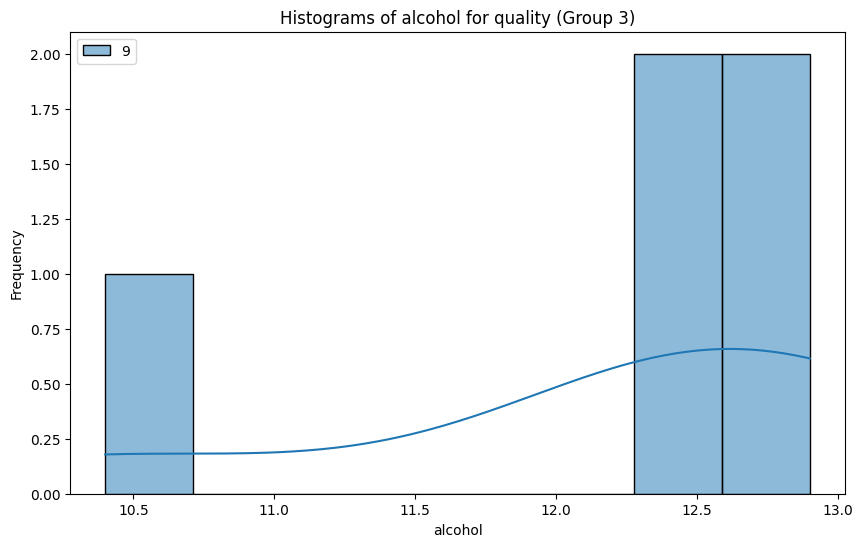

In [14]:
viz.plot_histograms_grouped(train_set, 'quality', target_reg)

La "class" no me dice demasiado porque sus KDE son similares (aunque uno más bajo que otro), pero en la "quality" sí hay mucha información

Features selected by correlation with target (threshold=0.1): ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH']


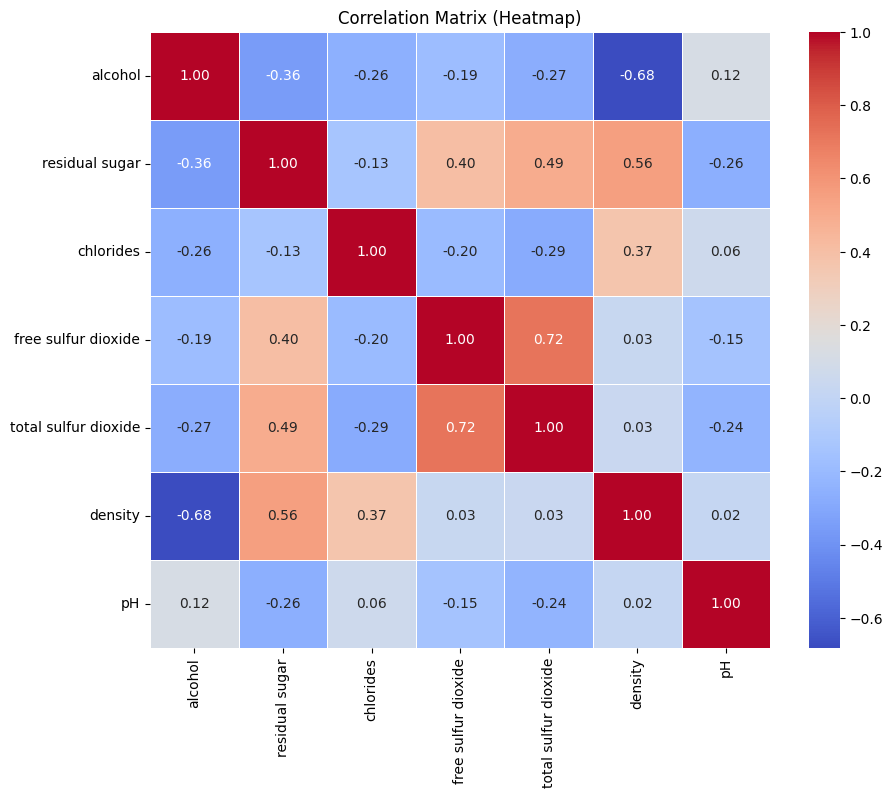

Correlation Matrix (DataFrame):


,alcohol,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH
alcohol,1.000000,-0.357459,-0.260508,-0.188460,-0.272970,-0.682345,0.116497
residual sugar,-0.357459,1.000000,-0.134384,0.402099,0.494696,0.555320,-0.264614
chlorides,-0.260508,-0.134384,1.000000,-0.198295,-0.287617,0.368711,0.064569
free sulfur dioxide,-0.188460,0.402099,-0.198295,1.000000,0.723322,0.030430,-0.149549
total sulfur dioxide,-0.272970,0.494696,-0.287617,0.723322,1.000000,0.034341,-0.241483
density,-0.682345,0.555320,0.368711,0.030430,0.034341,1.000000,0.018402
pH,0.116497,-0.264614,0.064569,-0.149549,-0.241483,0.018402,1.000000


Checking collinearity with residual sugar
	alcohol: 	Not in the original feature list. Doing nothing.
	residual sugar: 	This is the same feature. Not excluding.
	chlorides: 	Correlation is below the threshold. Keeping chlorides.
	free sulfur dioxide: 	Correlation is below the threshold. Keeping free sulfur dioxide.
	total sulfur dioxide: 	Correlation is below the threshold. Keeping total sulfur dioxide.
	density: 	Correlation is below the threshold. Keeping density.
	pH: 	Correlation is below the threshold. Keeping pH.
Checking collinearity with chlorides
	alcohol: 	Not in the original feature list. Doing nothing.
	residual sugar: 	Correlation is below the threshold. Keeping residual sugar.
	chlorides: 	This is the same feature. Not excluding.
	free sulfur dioxide: 	Correlation is below the threshold. Keeping free sulfur dioxide.
	total sulfur dioxide: 	Correlation is below the threshold. Keeping total sulfur dioxide.
	density: 	Correlation is below the threshold. Keeping density.
	pH:

(['total sulfur dioxide'],
 ['residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH'])

In [15]:
num_features = train_set.select_dtypes(include=['float64']).columns.to_list()
num_features.remove('alcohol')
ml.get_target_correlated_features(train_set, num_features, target_reg, 
                                  target_threshold=0.1, collinearity_threshold=0.7,
                                  visualize='both', verbose=True)

En las variables numéricas hemos encontrado que muchas tienen una correlación muy pobre con "alcohol", inferior al 0.1, así que elimino esas features y me quedo con bastantes pocas del dataset.

#### 3.4.4 Selección de features

Voy a tener dos sets de feaures:

- features_0: Contiene todas las features del set. Lo voy a probar porque en el problema de clasificación ha funcionado bien
- features_1: Elimina la categórica "class", y solo me quedo con las numéricas ['residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH'], que son las más altamente correladas con "alcohol".

### 3.5 Tratamiento de features

Las categóricas las voy a transformar a numéricas. Esto es algo necesario para los modelos de sklearn.

- Quality --> Ordinal Encoding. Pero es que en realidad ya están ordenadas por importancia. Lo que voy a hacer es un shift, y en realidad NO voy a hacer nada y ya la puedo empezar a tratar como numérica.
- Class --> One Hot Clasifier. Y para CatBoost ni si quiera hace falta.

Así tendré dos X_train

- X_train: el original
- X_train_encoded: con "class" codificada para los modelos que lo necesitan.

In [16]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,class
1916,7.9,0.18,0.40,2.2,0.049,38.0,67.0,0.99600,3.33,0.93,5,red
947,7.1,0.18,0.74,15.6,0.044,44.0,176.0,0.99960,3.38,0.67,6,white
877,7.6,0.51,0.24,1.2,0.040,10.0,104.0,0.99200,3.05,0.29,6,white
2927,6.0,0.25,0.28,7.7,0.053,37.0,132.0,0.99489,3.06,0.50,6,white
6063,9.0,0.38,0.41,2.4,0.103,6.0,10.0,0.99604,3.13,0.58,7,red


In [17]:
# One-Hot Encoding con pandas
X_train_encoded = pd.get_dummies(X_train, columns=['class'], drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=['class'], drop_first=True, dtype=int)


In [18]:
X_train_encoded.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,class_white
1916,7.9,0.18,0.40,2.2,0.049,38.0,67.0,0.99600,3.33,0.93,5,0
947,7.1,0.18,0.74,15.6,0.044,44.0,176.0,0.99960,3.38,0.67,6,1
877,7.6,0.51,0.24,1.2,0.040,10.0,104.0,0.99200,3.05,0.29,6,1
2927,6.0,0.25,0.28,7.7,0.053,37.0,132.0,0.99489,3.06,0.50,6,1
6063,9.0,0.38,0.41,2.4,0.103,6.0,10.0,0.99604,3.13,0.58,7,0


*No es necesario escalar para los modelos que voy a probar. 

Si por el contrario hubieras elegido una regresión lineal, una polinómca o alguna otra que dependa de las distancias, sí tendría que haber escalado las variables escogidas, igual que hice en el problema de clasificación.

### 3.6 Creación de los dataset de train y test


In [19]:
# Features para CatBoost
features_0 = X_train.columns
features_1 = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'class']

features_set_names = ['reducido', 'completo']
features_sets = [features_1, features_0]

X_train_dict = {}
X_test_dict = {}

for nombre, feature_list in zip(features_set_names, features_sets):
    X_train_dict[nombre] = X_train[feature_list]
    X_test_dict[nombre] = X_test[feature_list]

In [20]:
# X_train_dict['reducido']

In [21]:
# X_train_dict['completo']

In [22]:
# Features para los demás modelos
features_0 = X_train_encoded.columns
features_1 = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'class_white']

features_set_names = ['reducido', 'completo']
features_sets = [features_1, features_0]

X_train_encoded_dict = {}
X_test_encoded_dict = {}

for nombre, feature_list in zip(features_set_names, features_sets):
    X_train_encoded_dict[nombre] = X_train_encoded[feature_list]
    X_test_encoded_dict[nombre] = X_test_encoded[feature_list]

In [23]:
# X_train_encoded_dict['completo']

### 3.7 Instanciación de modelos

In [24]:
# El número de niveles para "probar" lo pongo más alto que en clasificación porque el rango de valores de la target es mucho mayor
rf_reg = RandomForestRegressor(max_depth=10, random_state=42) 
xgb_reg = XGBRegressor(max_depth=10, random_state=42)
lgb_reg = LGBMRegressor(max_depth=10, random_state=42, verbose=-100)
cat_reg = CatBoostRegressor(depth=10, random_seed=42, verbose=False)

modelos = {
    "Random Forest": rf_reg,
    "Lightgbm": lgb_reg,
    "XGBoost": xgb_reg,
    "CatBoost": cat_reg
}


### 3.8 Comparativa de modelos

Comparativa de modelos empleando cross_val_score (es decir la validación cruzada).

La métrica entonces emplea "mean_absolute_error"

Por algún motivo no he podido hacer el CatBoost con categóricas, así que le paso el X_train codificado también.

In [25]:
# Para scoring = precision
cv = 5
scoring = 'neg_mean_absolute_error'

# Sobre las features categóricas cuando pruebe el modelo de CatBoost
# Sobre las codificadas para todos los demás
for feature_set, X_train in X_train_dict.items():
    X_train_encoded = X_train_encoded_dict[feature_set]
    print(f"Para el set {feature_set}:")
    for tipo, modelo in modelos.items():
        print(f"{tipo}: ", end = " ")
        # if tipo == "CatBoost":
        #     print(-np.mean(cross_val_score(modelo, X_train, y_train, cv=cv, scoring=scoring)))
        if True:
            print(-np.mean(cross_val_score(modelo, X_train_encoded, y_train, cv=cv, scoring=scoring)))
    print("-------")

Para el set reducido:
Random Forest:  0.39039452984419654
Lightgbm:  0.3952394257062875
XGBoost:  0.341814775290117
CatBoost:  0.35956482089609415
-------
Para el set completo:
Random Forest:  0.32346038200434696
Lightgbm:  0.2820208900993424
XGBoost:  0.2579141124670481
CatBoost:  0.23743741925028408
-------


Por algún motivo no he podido hacer el CatBoost con categóricas, así que le paso el X_train codificado también.

De nuevo parece que el set completo tiene mejores resultados en todos los casos, y aunque `XGBoost` y `CatBoost`están bastante igualados en resultados, el primero es más simple y es el que voy a entrenar. Mi ordenador tarda mucho cuando intento hacer cosas con CatBoost.

### 3.9 Ajustar hiperparámetros.

In [26]:
# Hiperparámetros de XGBoost
cv = 5
scoring = 'neg_mean_absolute_error'

param_grid = {
       'n_estimators': [200, 500, 1000],
       'learning_rate': [0.01, 0.05],
       'max_depth': [3, 5, 7],
       'subsample': [0.5, 0.75],
       'colsample_bytree': [0.5, 0.75]
   }

xgb_grid = GridSearchCV(estimator=xgb_reg,
                       param_grid=param_grid,
                       cv=cv,
                       scoring=scoring,
                       n_jobs=-1)

# Entrenar con TODAS las features
xgb_grid.fit(X_train_encoded_dict['completo'], y_train)

print(xgb_grid.best_params_)
print(-xgb_grid.best_score_)

{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.5}
0.23567045992464833


In [52]:
ml.regression_report(xgb_grid.best_estimator_, X_test_encoded_dict['completo'], y_test)

MSE train 0.1232781809134107
RMSE train 0.35110992710746686
MAE train: 0.21961691465133282
MAPE train: 0.020791192015587042
R2 train 0.9125248590163672


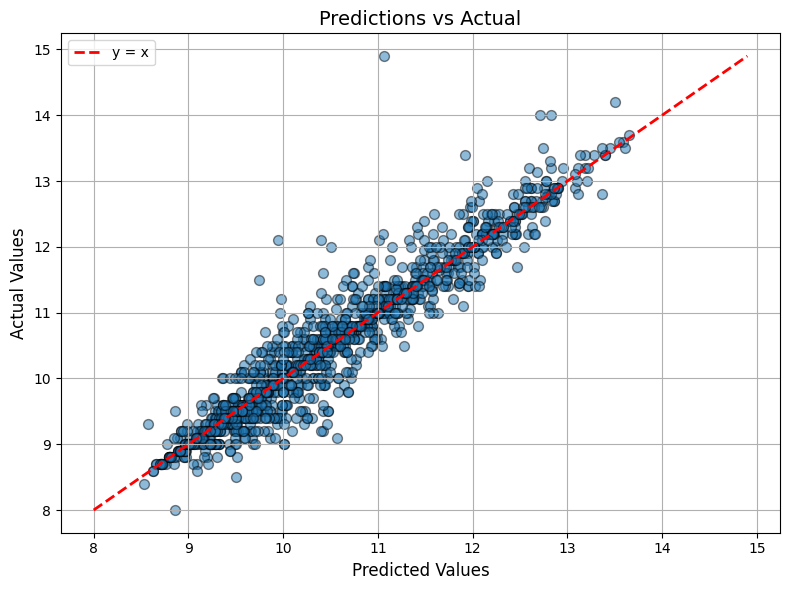

In [54]:
y_pred = xgb_grid.best_estimator_.predict(X_test_encoded_dict['completo'])
ml.plot_predictions_vs_actual(y_test, y_pred)

Es un modelo muy bueno, aún con algunos outliers.

In [28]:
# Hiperparámetros de CatBoost
cv = 5
scoring = 'neg_mean_absolute_error'

param_grid = {
       'iterations': [100, 300, 600],
       'learning_rate': [0.01, 0.05],
       'depth': [3, 5, 7, 10],
       'l2_leaf_reg': [1, 4, 7],
       'bagging_temperature': [0, 10, 20]
   }

cat_grid = GridSearchCV(estimator=cat_reg,
                       param_grid=param_grid,
                       cv=cv,
                       scoring=scoring,
                       n_jobs=-1)

# Entrenar con TODAS las features
cat_grid.fit(X_train_encoded_dict['completo'], y_train)

print(cat_grid.best_params_)
print(-cat_grid.best_score_)

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bagging_temperature': 0, 'depth': 10, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
0.24557082248001075


In [55]:
ml.regression_report(cat_grid.best_estimator_, X_test_encoded_dict['completo'], y_test)

MSE train 0.12562848335438453
RMSE train 0.35444108587236967
MAE train: 0.23539653988798848
MAPE train: 0.022280547825766342
R2 train 0.9108571426706598


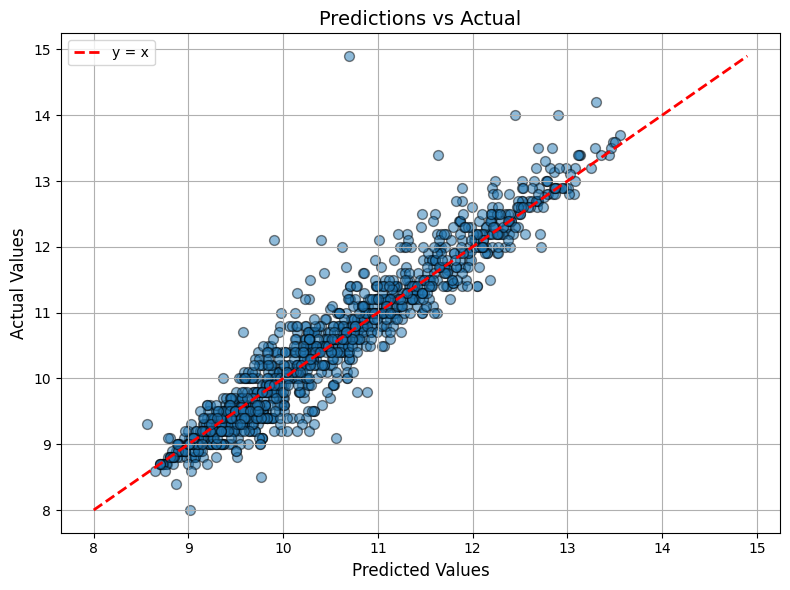

In [56]:
y_pred = cat_grid.best_estimator_.predict(X_test_encoded_dict['completo'])
ml.plot_predictions_vs_actual(y_test, y_pred)

Al final también he ajustado los hiperparámetros de CatBoost pero ha resultado ser algo peor que XGBoost en todo salvo en R^2.

### 3.10 Guardar modelos con pickle

In [57]:
# Guardar modelos con "pickle"

# Creamos el directorio si no existe
os.makedirs('models', exist_ok=True)

# Guardar el modelo KNN un archivo
with open('./models/xgb_reg_wine.pkl', 'wb') as file:
    pickle.dump(xgb_grid, file)
    
# Guardar el modelo KNN un archivo
with open('./models/cat_clf_wine.pkl', 'wb') as file:
    pickle.dump(cat_grid, file)